## For문을 통해 수정한 코드

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
from tools_ryu import mytool

In [2]:
data = pd.read_pickle("Data/cmktcap_data_final.pickle")

vol = pd.pivot_table(data=data,
                     values="vol", 
                     index="date", 
                     columns="coin_id")

price = pd.pivot_table(data=data,
                     values="close", 
                     index="date", 
                     columns="coin_id").replace({0:np.nan})

mktcap = pd.pivot_table(data=data,
                     values="mktcap", 
                     index="date", 
                     columns="coin_id")

In [3]:
daily_rtn = price.pct_change(fill_method=None)

In [4]:
# Setting the threshold value
vol_thresh = 1_000_000
mktcap_thresh = 1_000_000

vol_mask = (vol.rolling(window=30).mean() > vol_thresh) \
               .replace({True: 1,
                         False:np.nan
                         })

mktcap_mask = (mktcap.rolling(window=30).mean() > mktcap_thresh) \
                     .replace({True: 1,
                               False:np.nan
                               })
                     
mktcap_screened = (mktcap * mktcap_mask * vol_mask)
# price는 forward-look bias가 생길 수 있기 때문에 masking 해 주지 않는다

In [5]:
# mktcap, vol 스크리닝을 했기 때문에, 코인이 1개라도 포함되는 시작일을 찾아야 한다(mkt index 계산을 위해서)
start_idx = (mktcap_screened.isna().sum(1) < mktcap_screened.shape[1]) \
                            .replace(False,np.nan) \
                            .dropna() \
                            .index[0]
print(start_idx)

# 마켓 인덱스 만들기
weight = mktcap_screened.loc[start_idx:].apply(lambda x: x / np.nansum(x), axis=1)
mkt_index = (daily_rtn*weight.shift(1)).sum(1)

2013-12-27 00:00:00


    resample("W") : 일요일 리벨런싱

In [6]:
weekly_mktcap = mktcap_screened.loc[start_idx:].resample("W").last()
weekly_rtn = price.loc[start_idx:].pct_change(7,fill_method=None) \
                                  .resample("W").last()
weekly_price = price.loc[start_idx:].resample("W").last()
weekly_vol_mask = vol_mask.loc[start_idx:].resample("W").last()

In [7]:
# Momentum 그룹을 구하기 위해서 필요함
weekly_rtn_screened = weekly_rtn * np.sign(weekly_mktcap) * weekly_vol_mask

In [8]:
# 언제부터 시작하는 지 찾자 (최소 100개의 코인이 필요)
cnt = weekly_rtn_screened.count(1)
more100 = cnt.loc[cnt > 99] # 여기서 start date가 나온다
start = more100.index[0]
more100

date
2017-12-03    106
2017-12-10    116
2017-12-17    140
2017-12-24    161
2017-12-31    175
             ... 
2023-03-19    592
2023-03-26    590
2023-04-02    581
2023-04-09    577
2023-04-16    571
Freq: W-SUN, Length: 281, dtype: int64

In [9]:
weekly_rtn_sample_pp = weekly_rtn_screened.loc[start:]
weekly_mktcap_sample = weekly_mktcap.loc[start:]
weekly_price_sample = weekly_price.loc[start:]

In [10]:
# rank를 계산해줍니다
rank = weekly_rtn_sample_pp.rank(axis=1, method="first")

# rank가 존재하는 코인의 수를 구합니다
coin_count = rank.count(axis=1)

# 그룹별로 동일한 코인 수를 포함하기 위해 각 그룹의 rank thresh를 생성해줍니다
rank_thresh = coin_count.apply(lambda x: [i for i in range(0,x, x//5)])

t1 = rank_thresh.apply(lambda x: x[1])
t2 = rank_thresh.apply(lambda x: x[2])
t3 = rank_thresh.apply(lambda x: x[3])
t4 = rank_thresh.apply(lambda x: x[4])

rank_thresh

date
2017-12-03        [0, 21, 42, 63, 84, 105]
2017-12-10        [0, 23, 46, 69, 92, 115]
2017-12-17            [0, 28, 56, 84, 112]
2017-12-24       [0, 32, 64, 96, 128, 160]
2017-12-31           [0, 35, 70, 105, 140]
                          ...             
2023-03-19    [0, 118, 236, 354, 472, 590]
2023-03-26         [0, 118, 236, 354, 472]
2023-04-02    [0, 116, 232, 348, 464, 580]
2023-04-09    [0, 115, 230, 345, 460, 575]
2023-04-16    [0, 114, 228, 342, 456, 570]
Freq: W-SUN, Length: 281, dtype: object

In [11]:
g1_mask = rank.apply(lambda x: x <= t1, axis=0) \
              .replace({True:1, False:np.nan})
g2_mask = rank.apply(lambda x: (t1 < x)&(x <= t2), axis=0) \
              .replace({True:1, False:np.nan})
g3_mask = rank.apply(lambda x: (t2 < x)&(x <= t3), axis=0) \
              .replace({True:1, False:np.nan})
g4_mask = rank.apply(lambda x: (t3 < x)&(x <= t4), axis=0) \
              .replace({True:1, False:np.nan})
g5_mask = rank.apply(lambda x: x > t4, axis=0) \
              .replace({True:1, False:np.nan})           

In [12]:
# 각 그룹별 weight를 생성
weight_g1 = (g1_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g2 = (g2_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g3 = (g3_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g4 = (g4_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g5 = (g5_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)

# 여기까지가 t기에 weight를 구하는 과정까지다 
each_weight = {"Q1":weight_g1,
               "Q2":weight_g2,
               "Q3":weight_g3,
               "Q4":weight_g4,
               "Q5":weight_g5
               }

In [13]:
# 그룹별 코인 개수 출력 
concat = pd.concat([weight_g1.count(1), weight_g2.count(1),
                    weight_g3.count(1), weight_g4.count(1),
                    weight_g5.count(1)], axis=1)#.plot();

coin = pd.concat([concat, concat.sum(1)], axis=1)
coin.columns = [0,1,2,3,4,"Sum"]
coin

,0,1,2,3,4,Sum
date,,,,,,
2017-12-03,21,21,21,21,22,106
2017-12-10,23,23,23,23,24,116
2017-12-17,28,28,28,28,28,140
2017-12-24,32,32,32,32,33,161
2017-12-31,35,35,35,35,35,175
...,...,...,...,...,...,...
2023-03-19,118,118,118,118,120,592
2023-03-26,118,118,118,118,118,590
2023-04-02,116,116,116,116,117,581


In [14]:
final_value = {}

for key, weight_matrix in tqdm(each_weight.items(),desc="Processing dictionary"):
    pf_value = 1
    strategy_rtn = {}

    for t in weight_matrix.index:
        dollar_value = weight_matrix.loc[t] * pf_value    # 포트폴리오가 담을 각 코인의 달러가치

        # 여기까지가 t기 close에 momentum을 계산하고, 몇 개의 코인을 살지 결정한 것이다
        ## t+1기 부터 t+7기 close까지 수익을 계산해야 한다
        t_1, t_7 = t + pd.Timedelta(days=1), t + pd.Timedelta(days=7)
        for date in pd.date_range(t_1, t_7):
            if date > weight_matrix.index[-1]: # 우리가 가진 데이터의 기간 밖이면 break
                break
            dollar_value = dollar_value * (1+daily_rtn.loc[date]) #코인의 dollar value 변화를 추적
            pf_value = dollar_value.sum()
            strategy_rtn[str(date.strftime("%Y-%m-%d"))] = pf_value
    # 저장
    pf_save = pd.Series(strategy_rtn)
    pf_save.index = pd.to_datetime(pf_save.index)
    pf_save[pf_save.index[0] - pd.Timedelta(days=1)] = 1 # 투자 시작일 포트폴리오 가치를 1로 셋팅
    final_value[key] = pf_save.sort_index().pct_change().fillna(0)

Processing dictionary: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


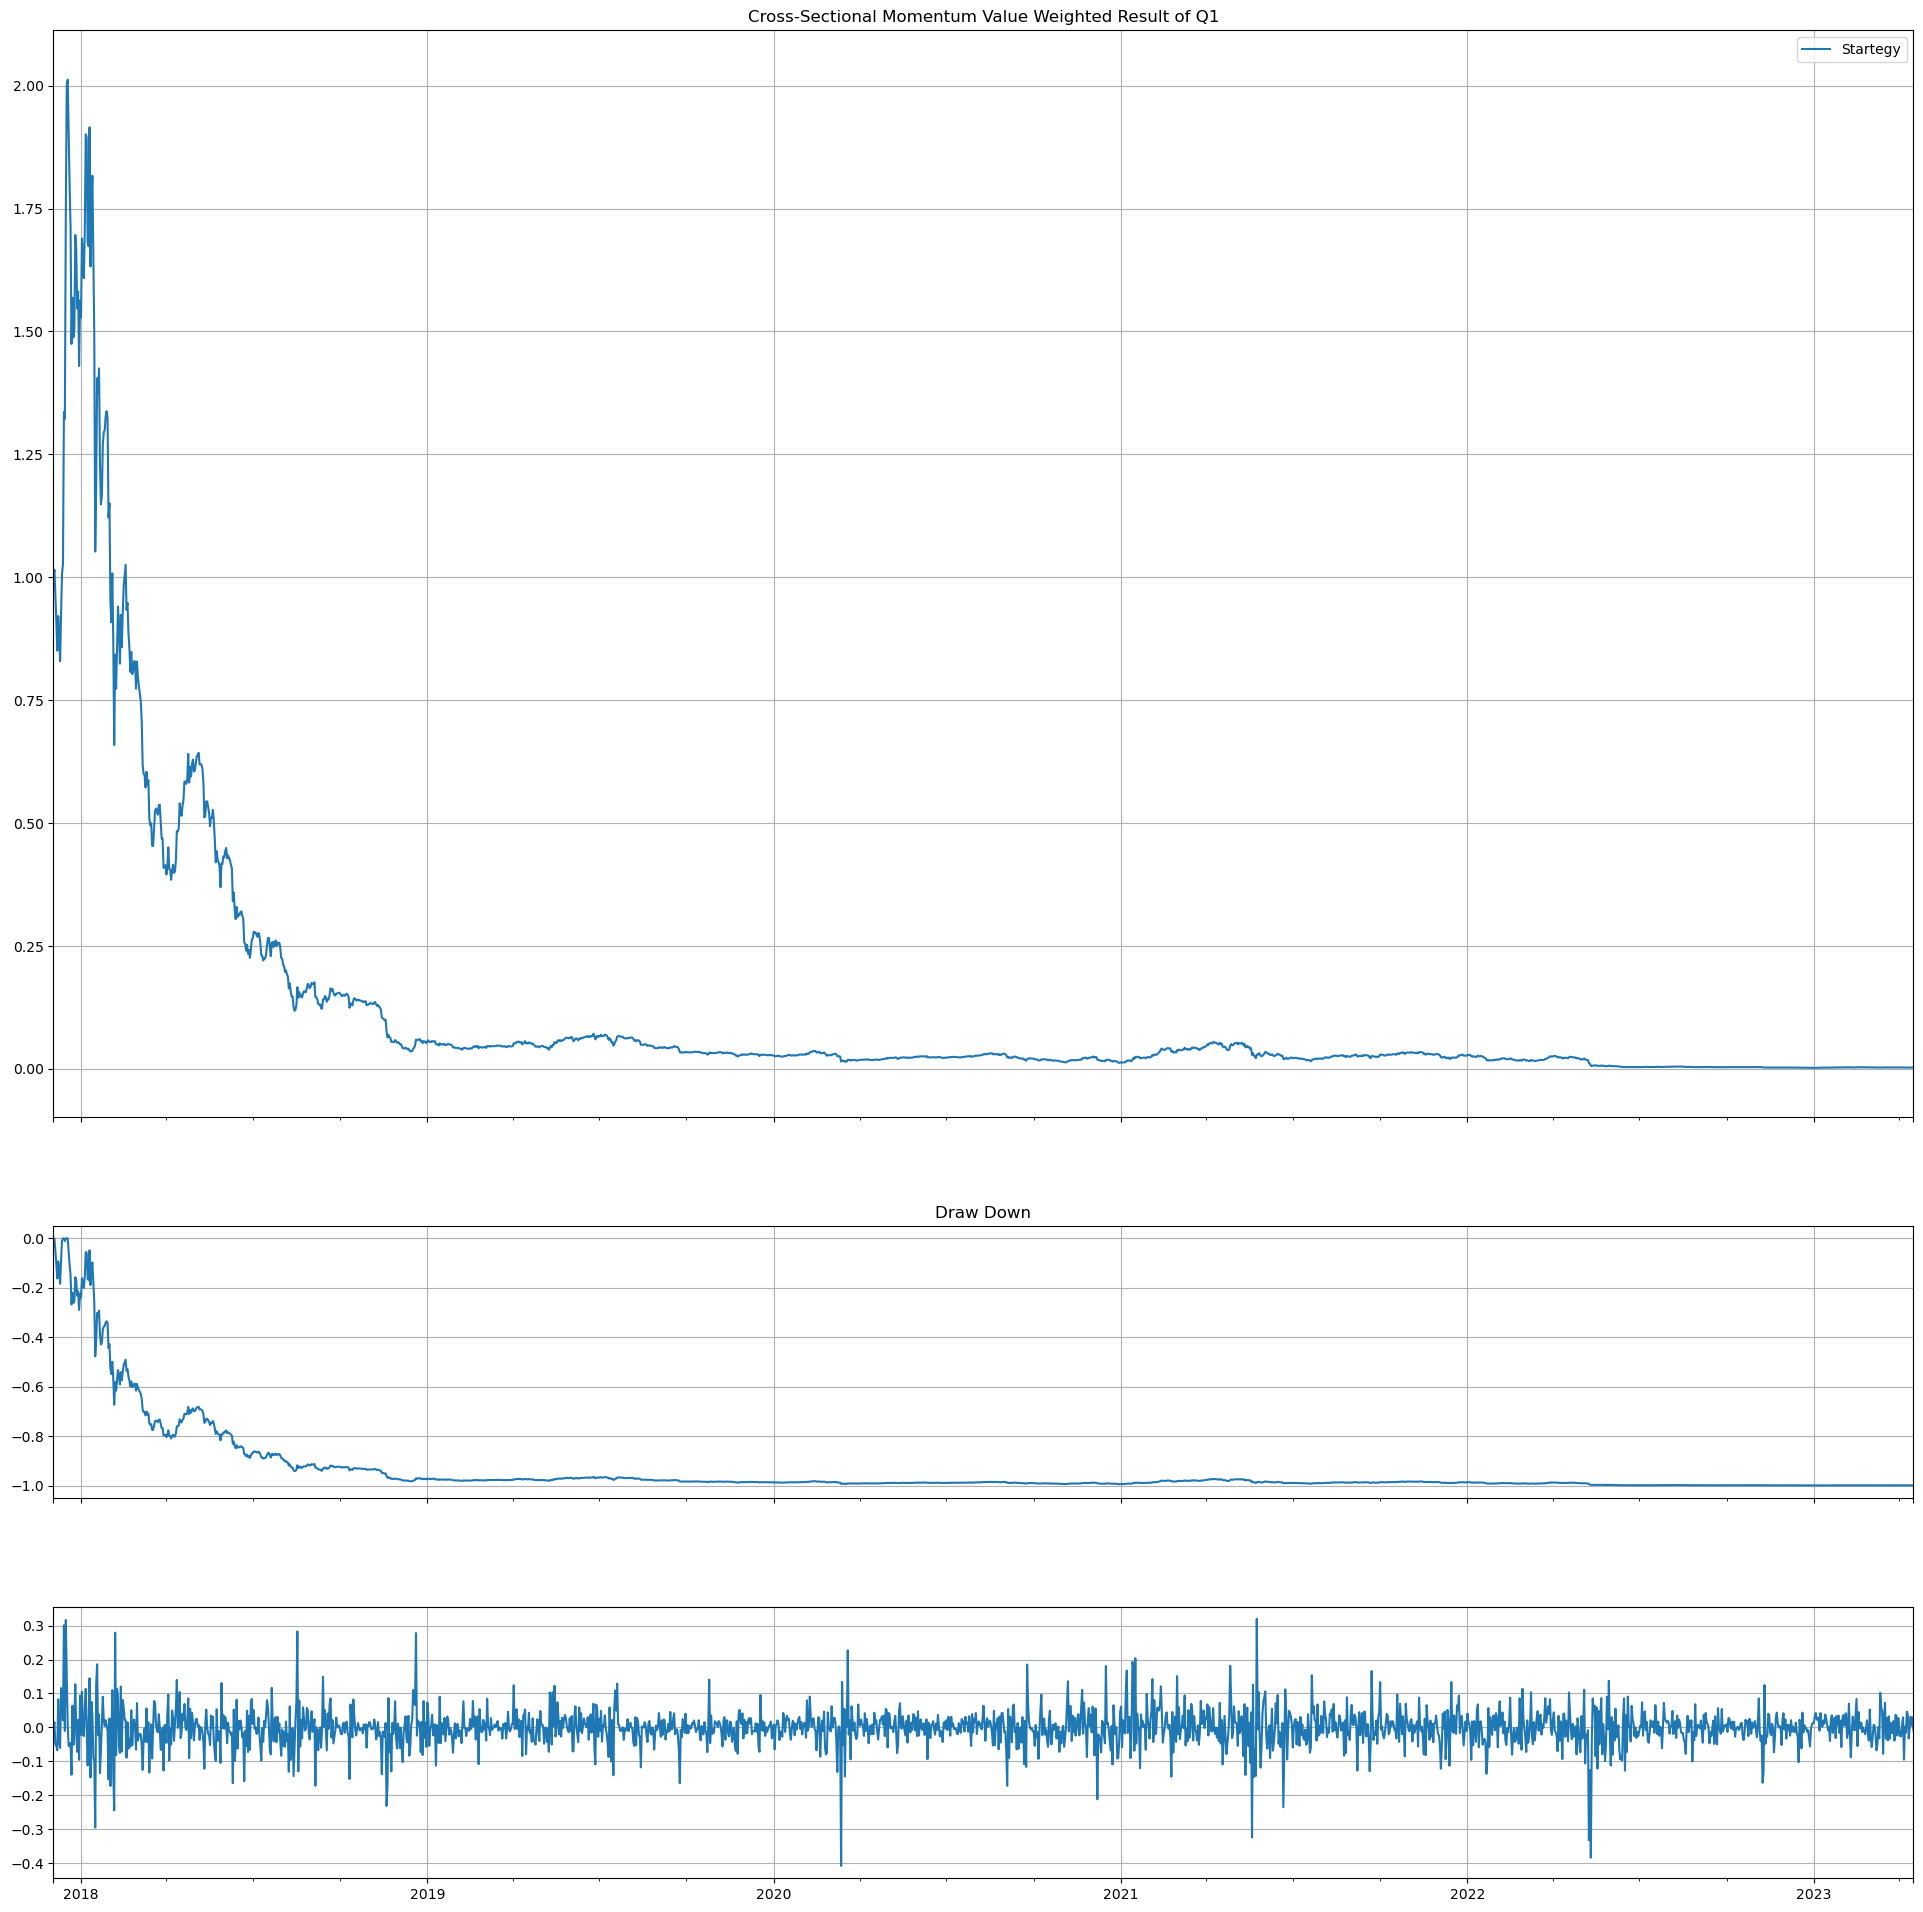

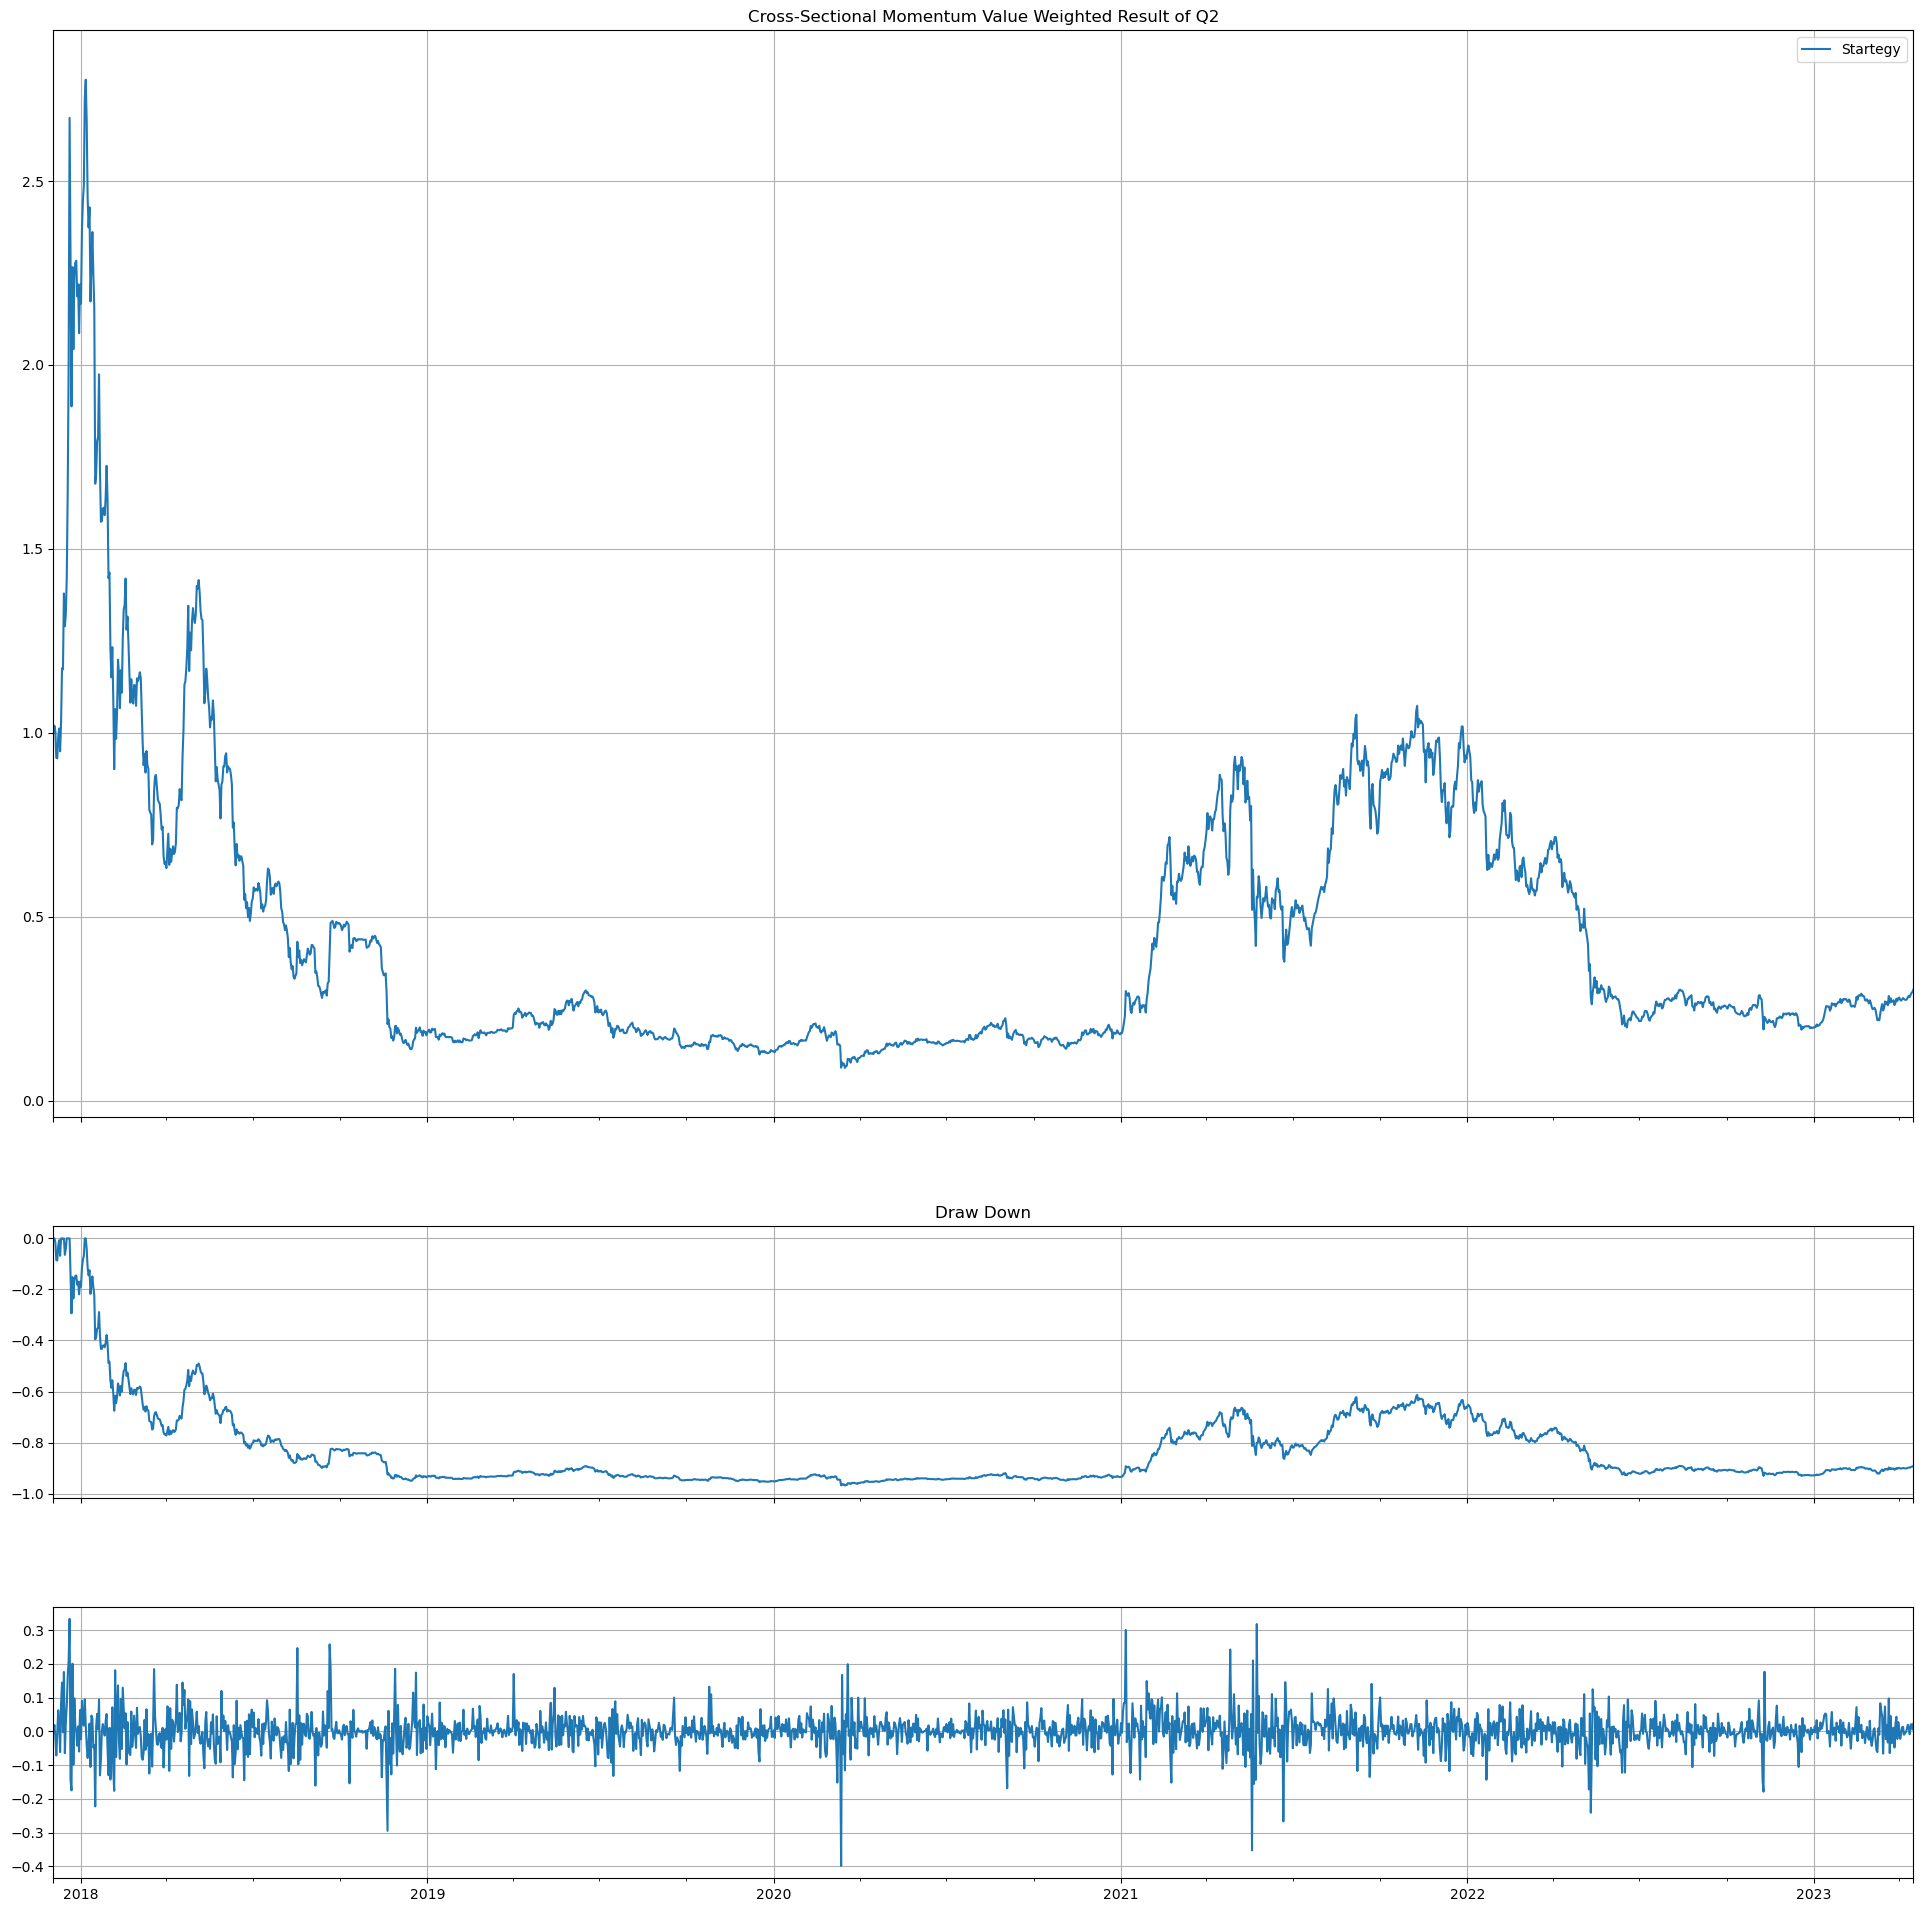

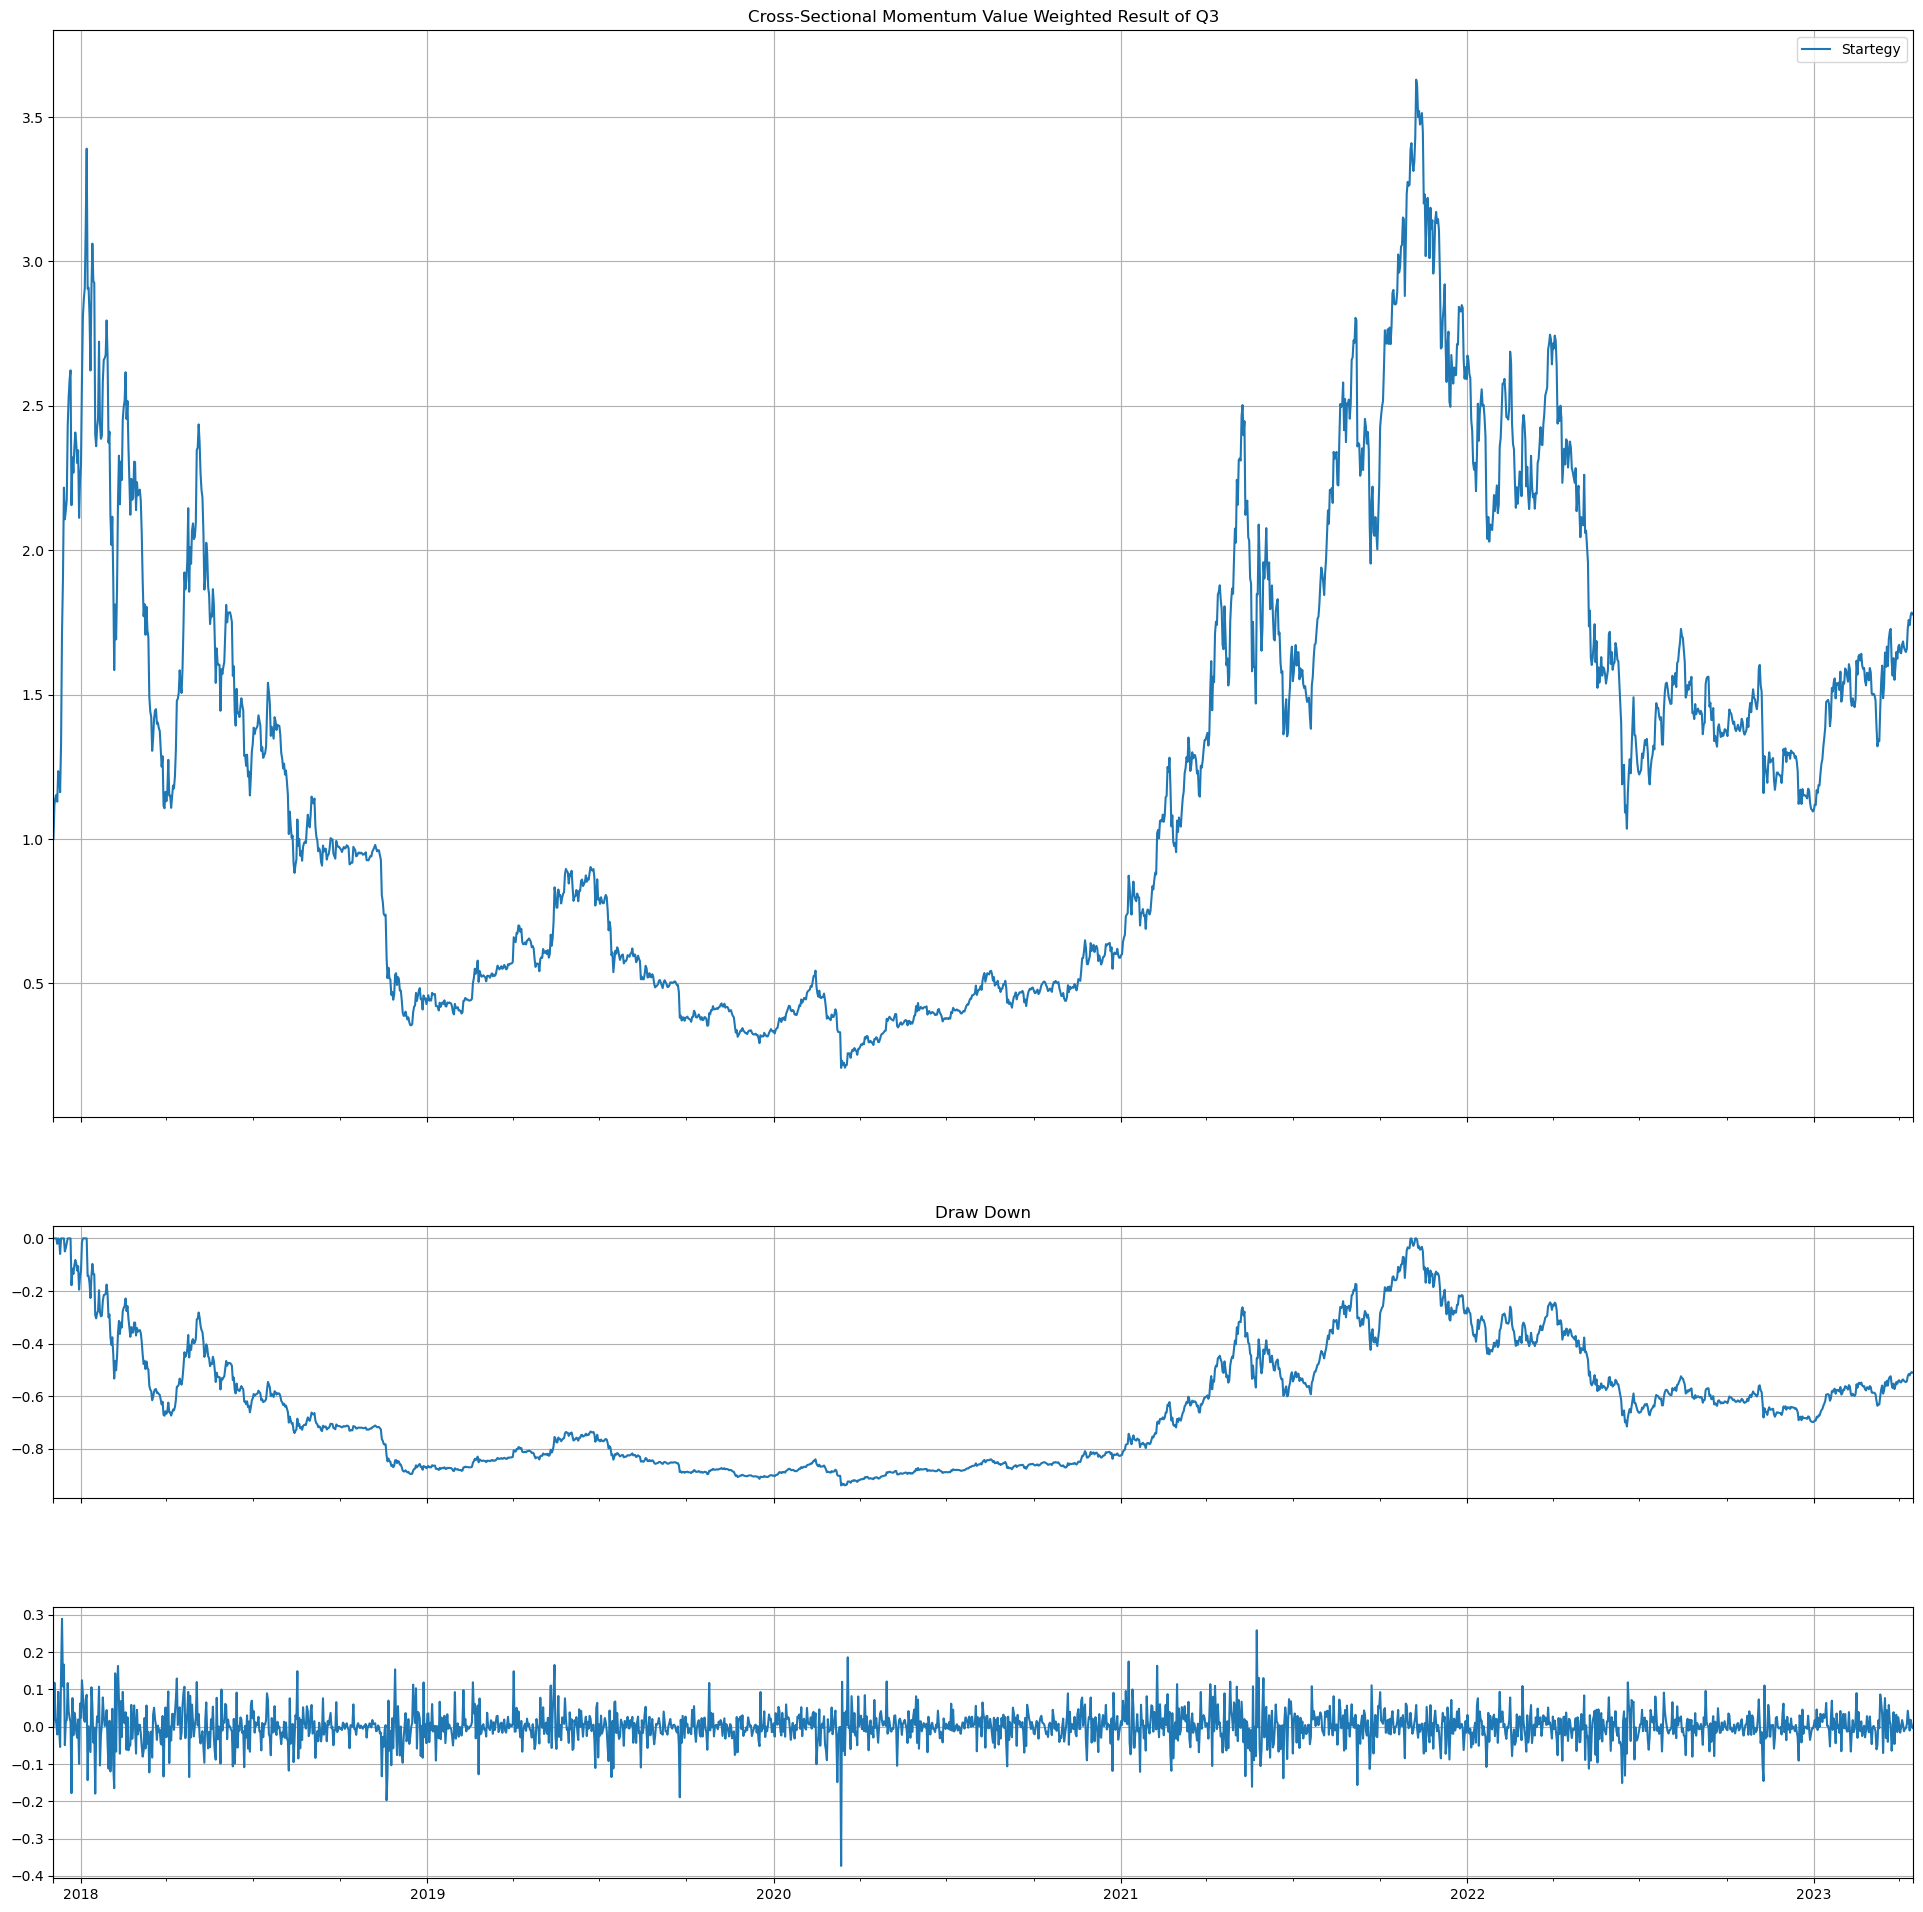

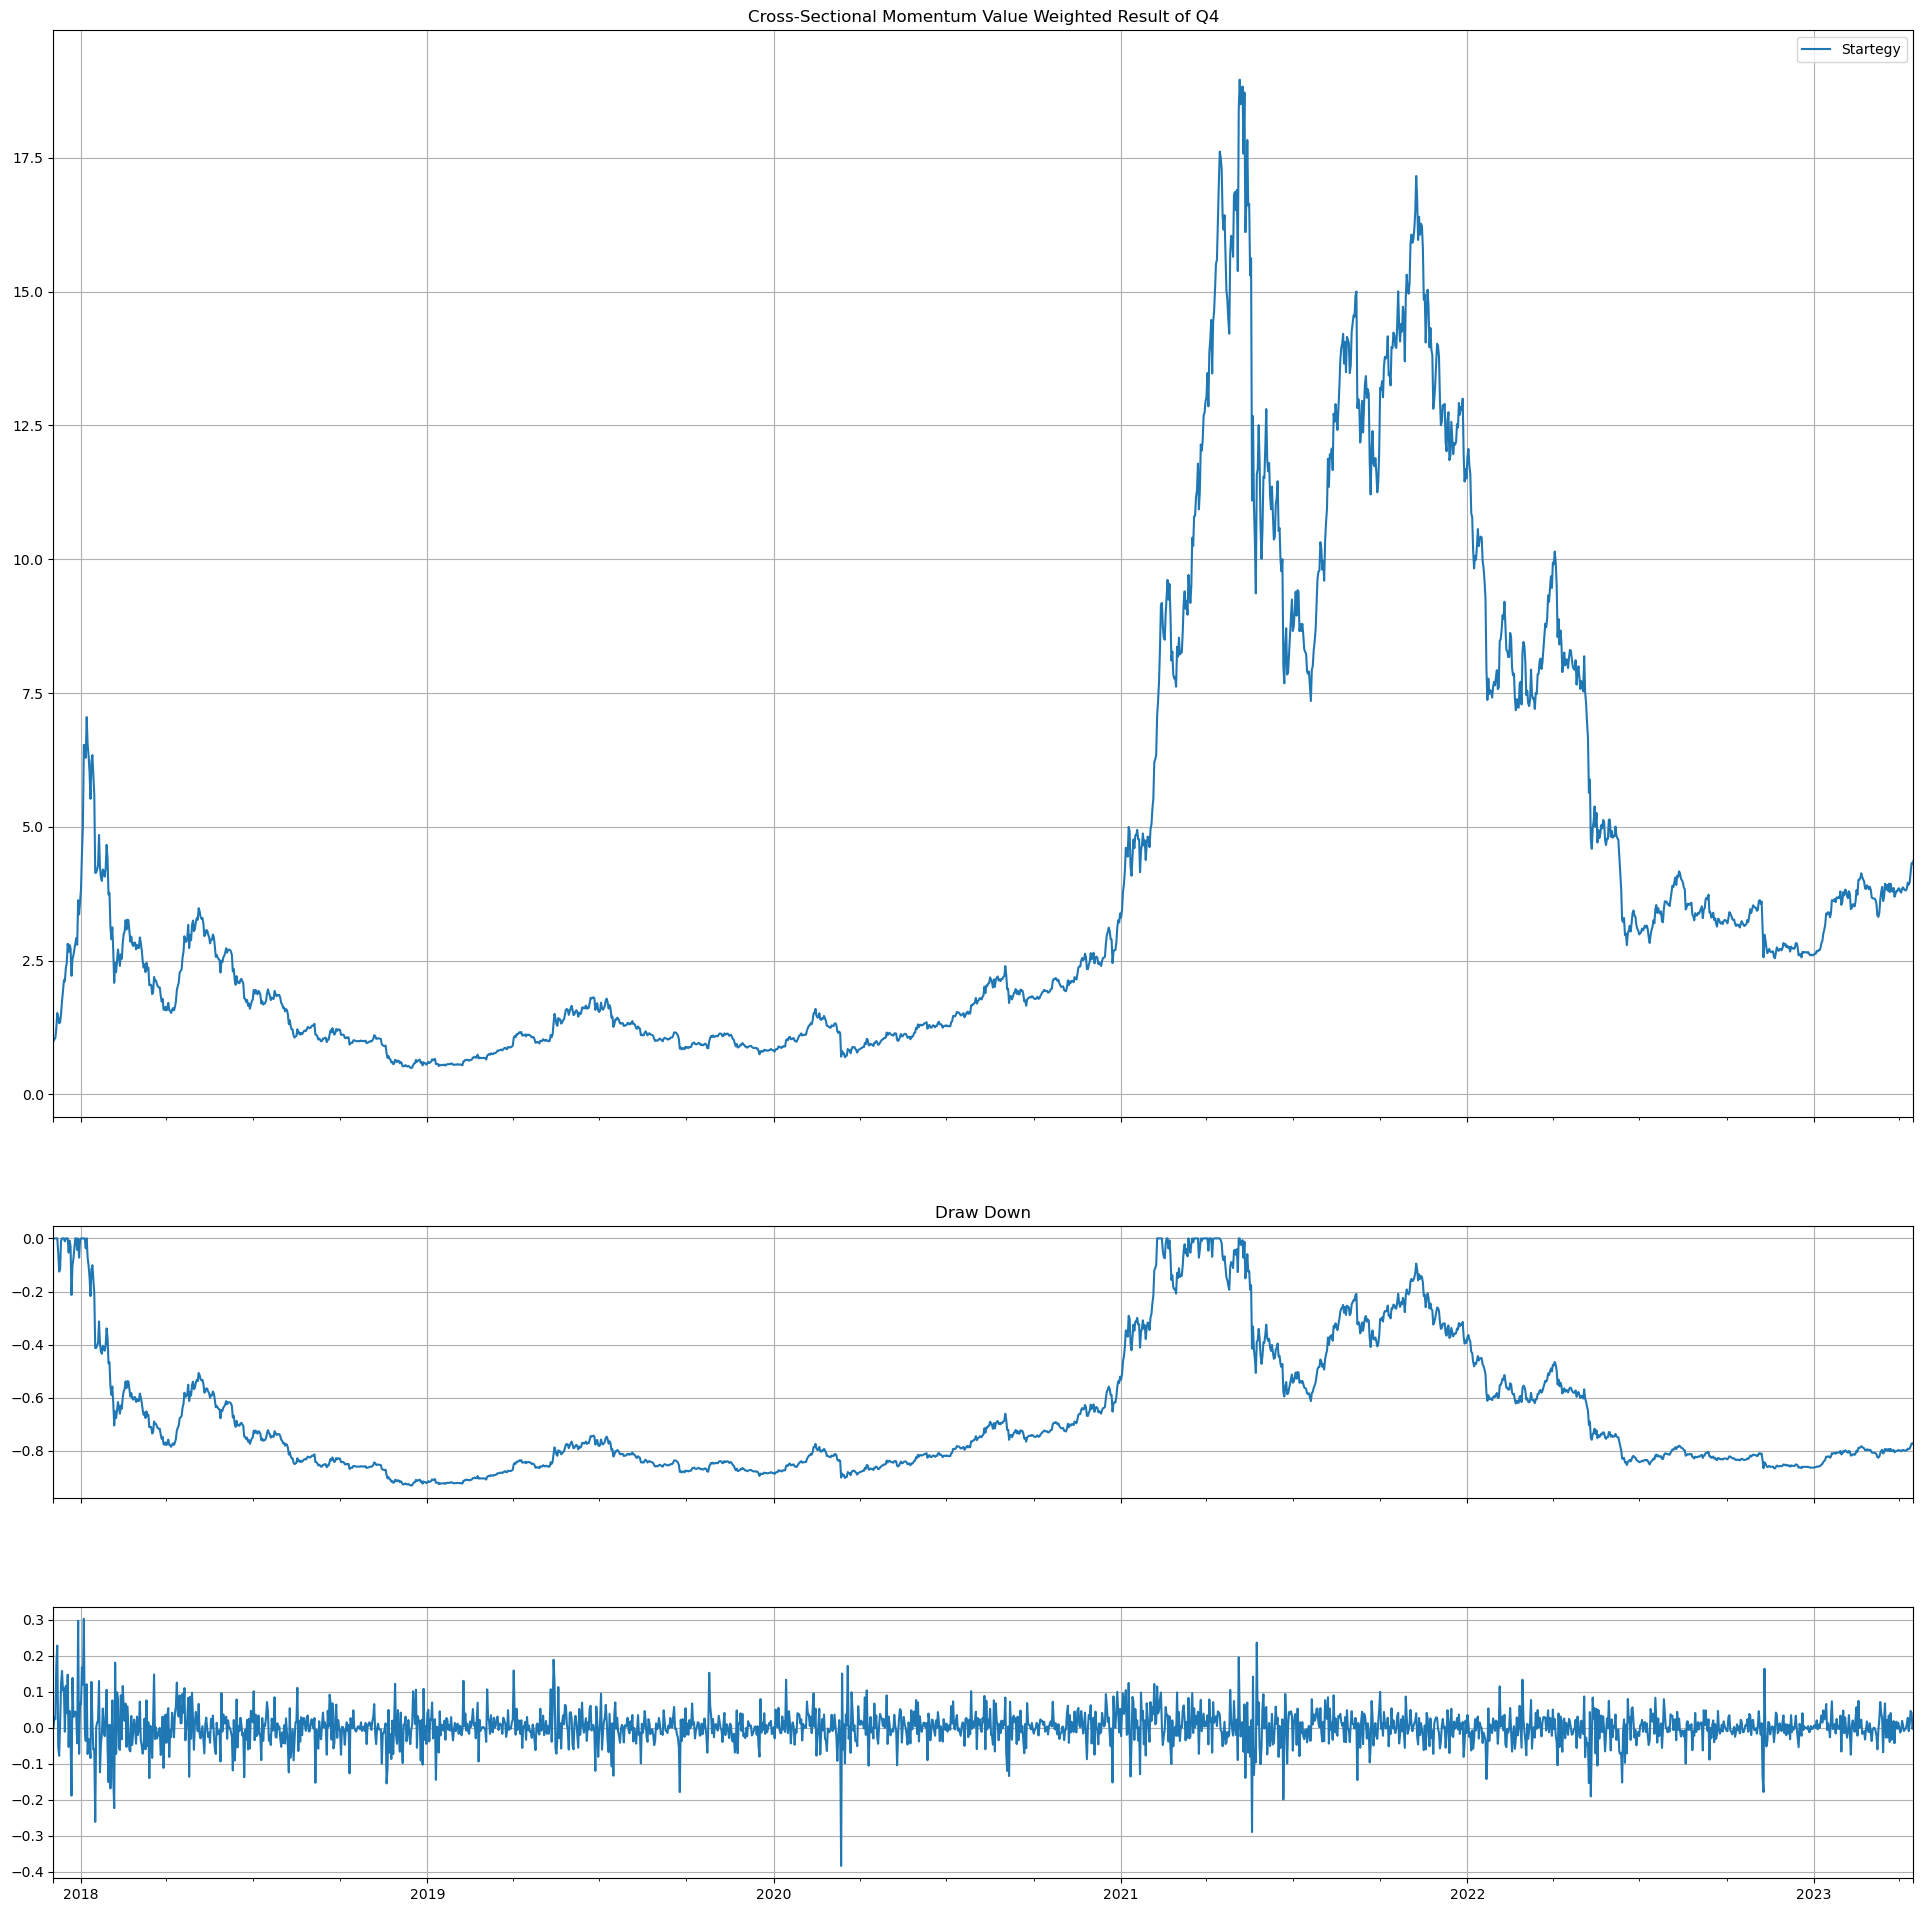

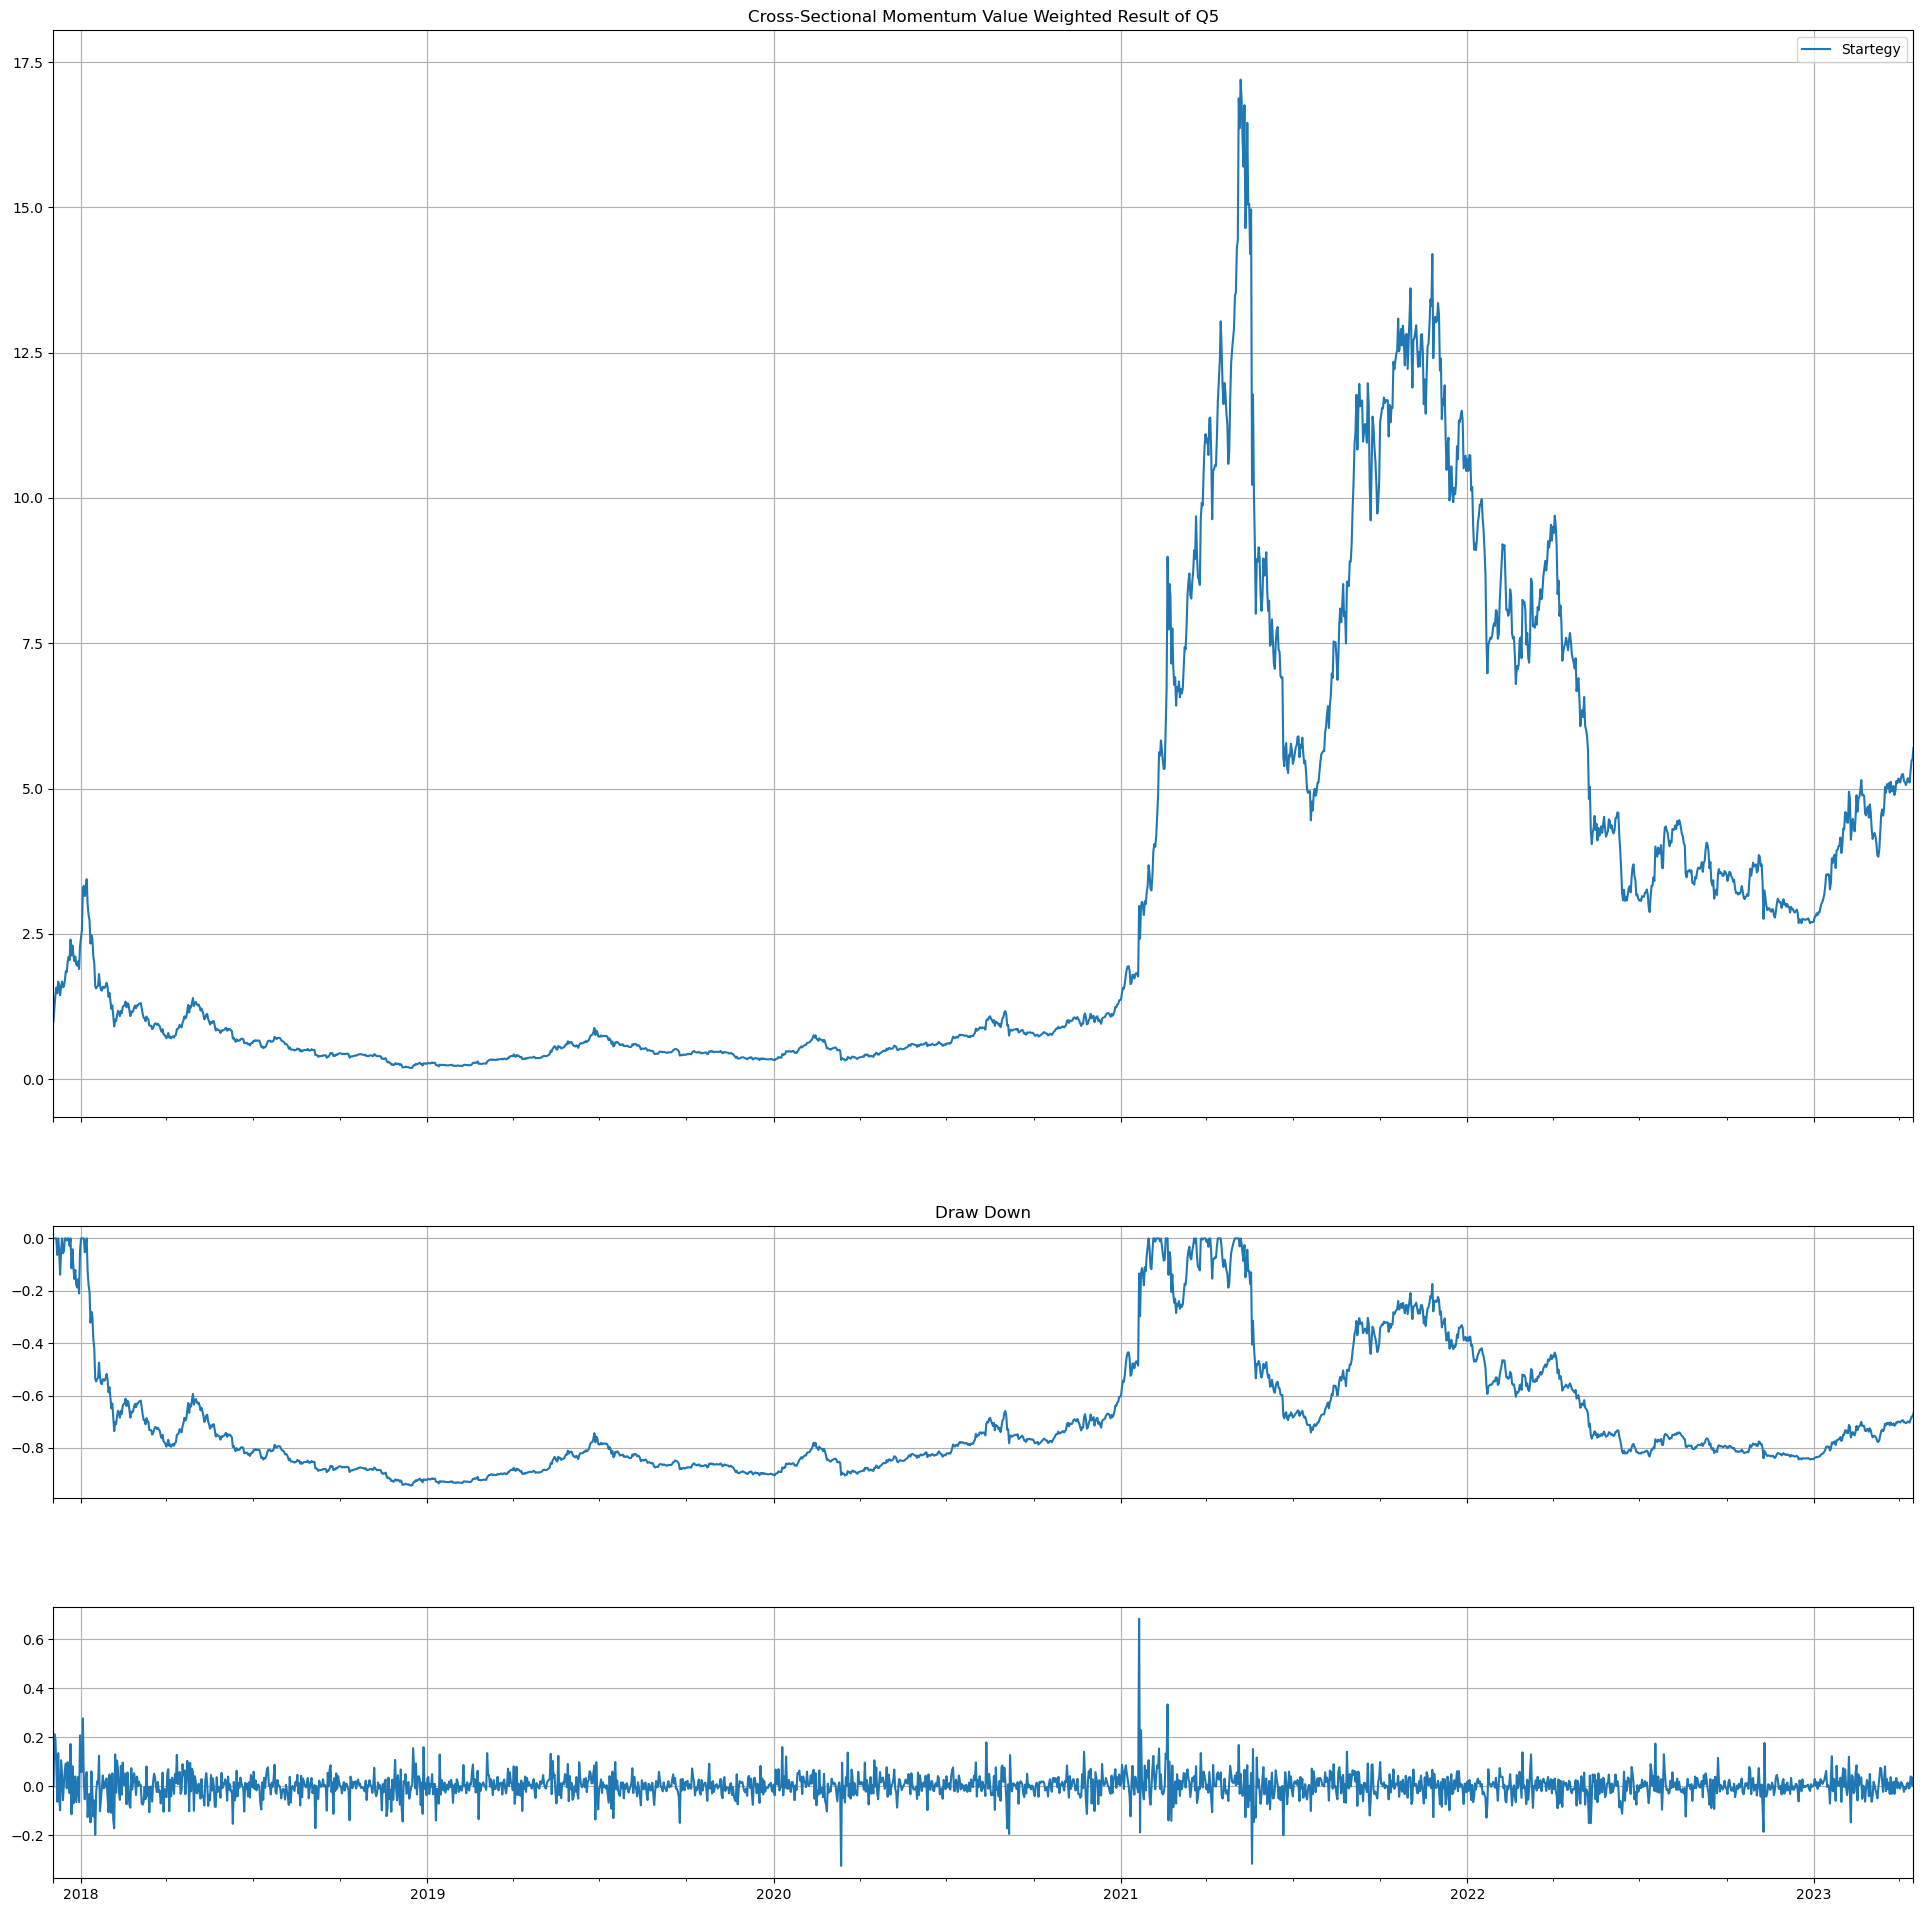

In [15]:
mytool.draw_return_result(final_value)

In [16]:
mytool.print_statistics(final_value)

,0,1,2,3,4
CAGR,-66.2974%,-20.2597%,9.0558%,30.845899999999997%,33.393499999999996%
Mean,-0.510767,0.274034,0.48497,0.715269,0.814179
STD,1.054926,0.98865,0.86359,0.931324,0.998622
MDD,0.999,0.968,0.939,0.93,0.943
Sharpe,-0.484174,0.27718,0.561575,0.768013,0.815303


In [20]:
ls = final_value["Q5"] - final_value["Q1"]

long_short = {"ls":ls}

In [24]:
long_short["ls"].max()

0.6939836276584843

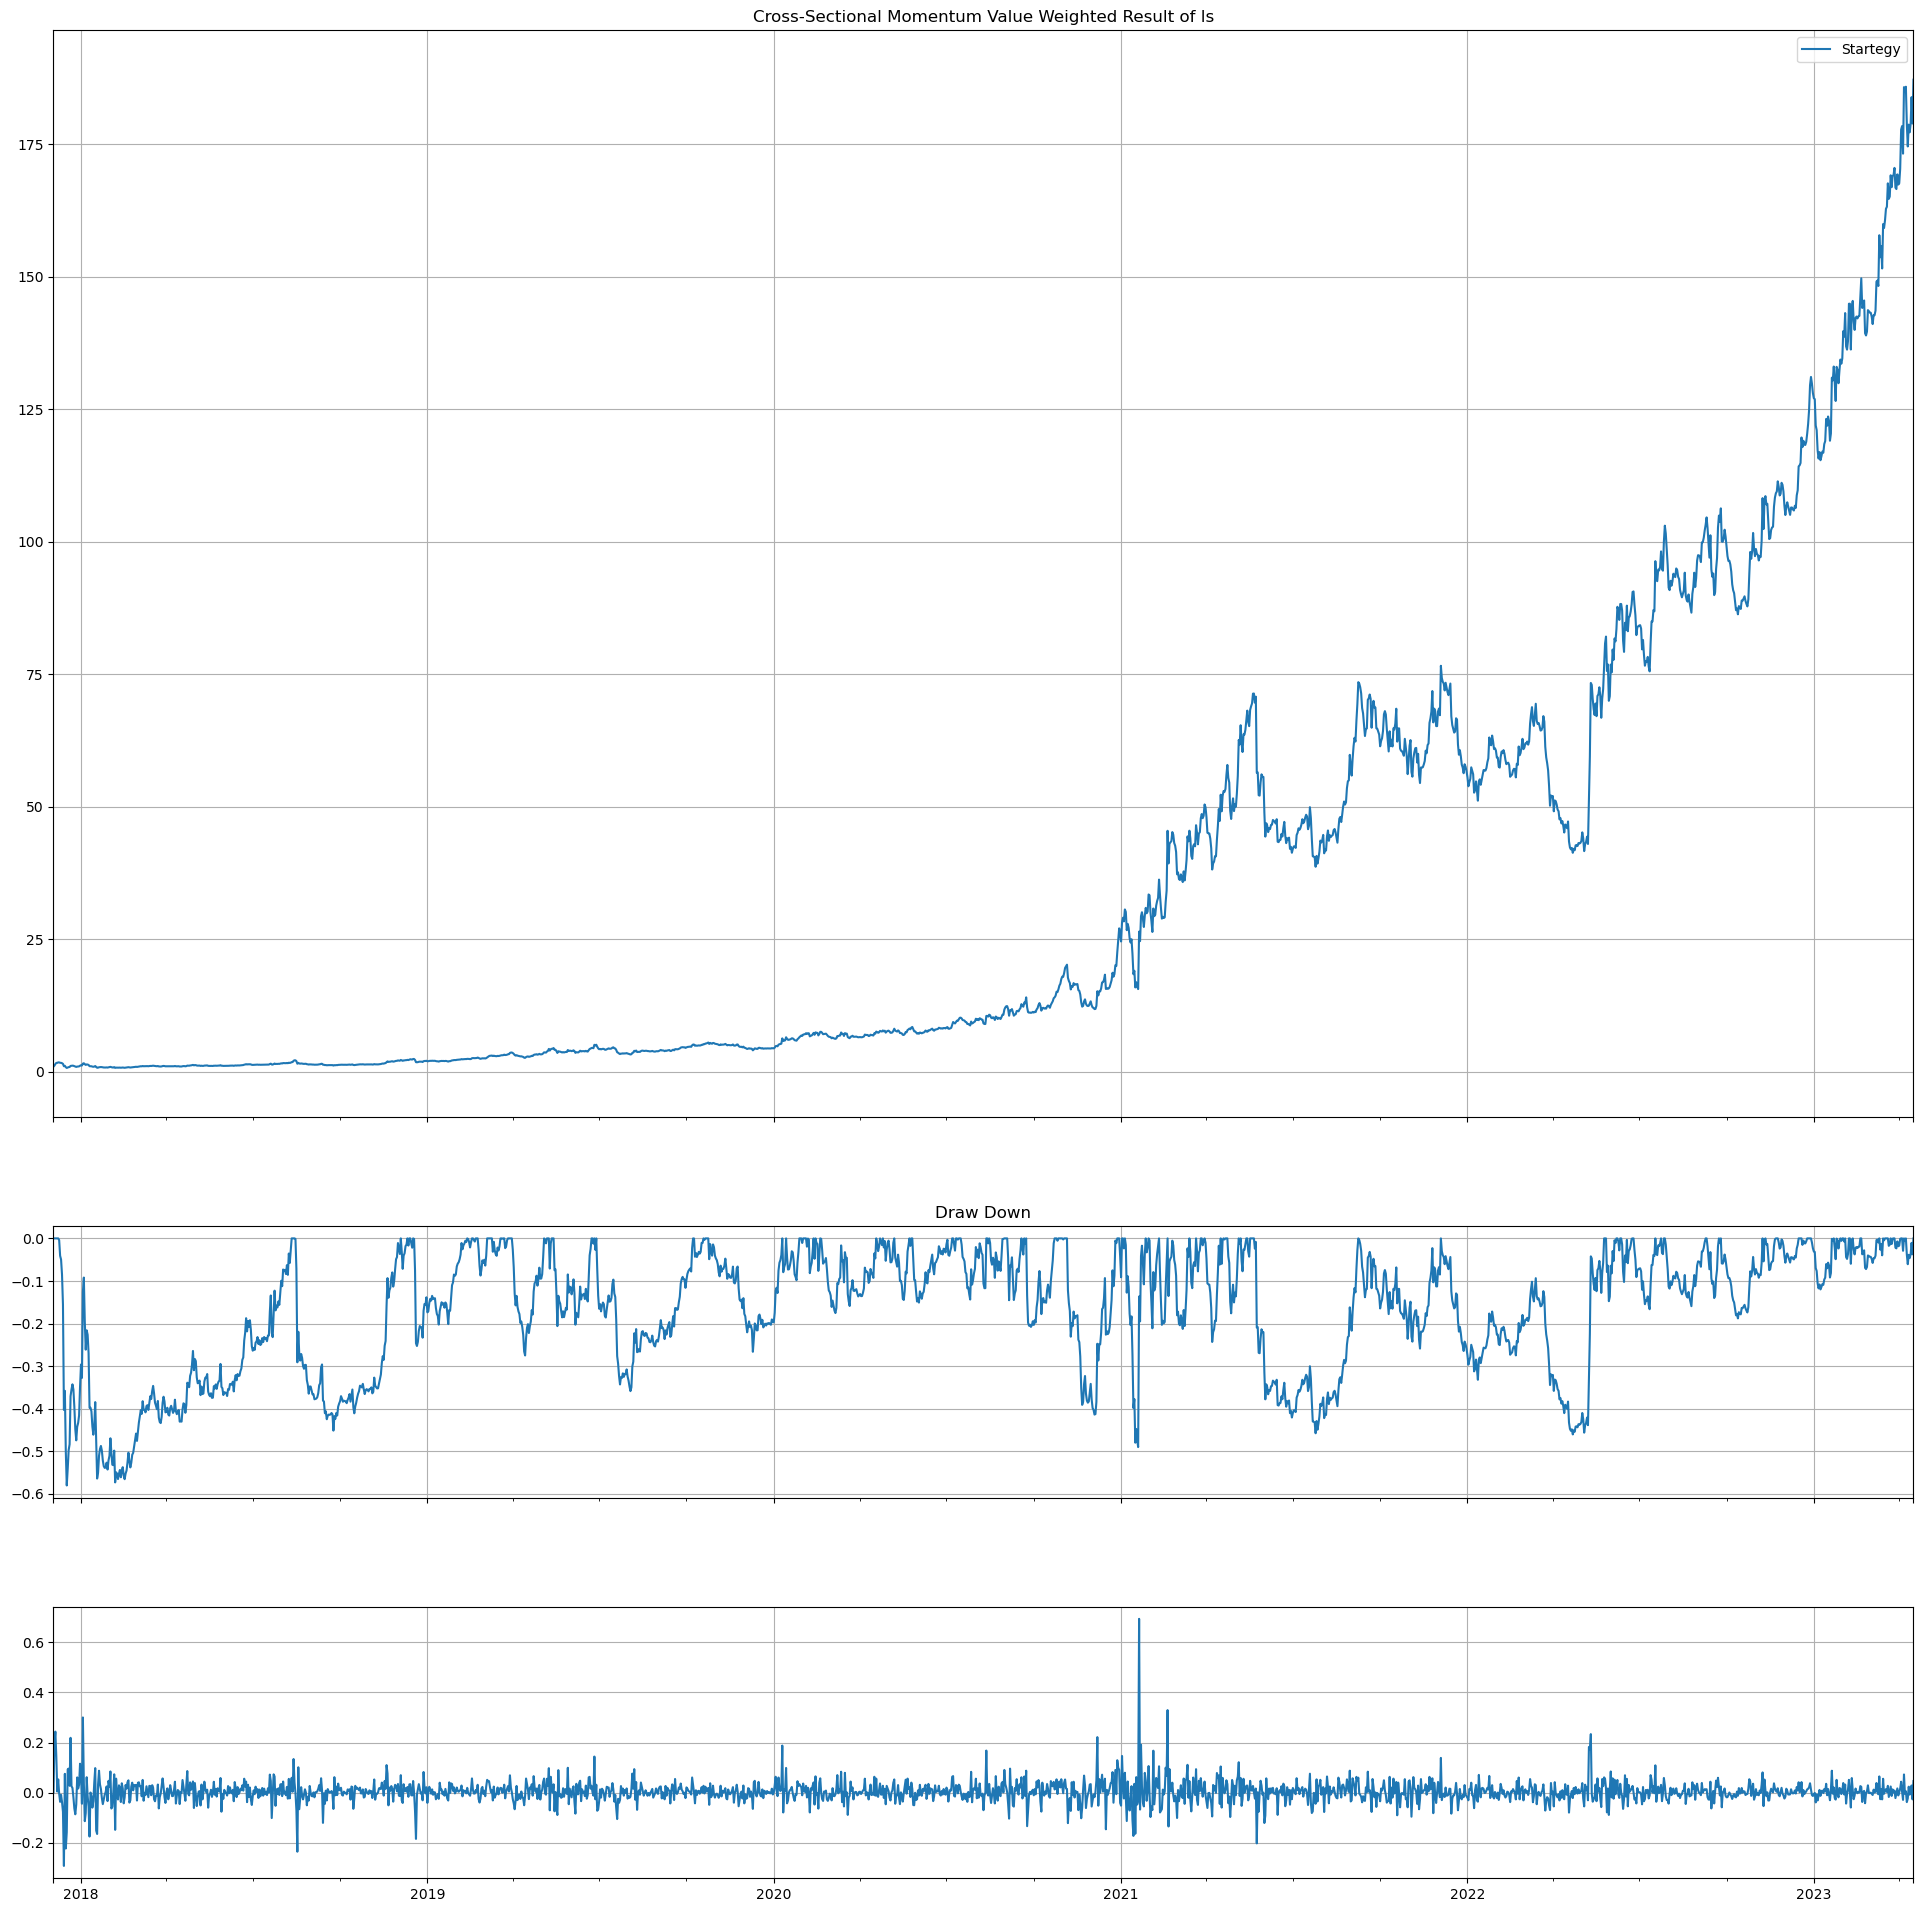

In [18]:
mytool.draw_return_result(long_short)

In [21]:
mytool.print_statistics(long_short)

,0
CAGR,156.1734%
Mean,1.324946
STD,0.853118
MDD,0.58
Sharpe,1.553063
